In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.utils import functions, path
from spectrome.brain import Brain


from spectrome.forward import ntf_local_stimulus as nt_stim
from spectrome.forward import ntf_local as nt_nostim
from spectrome.forward import ntf_local_stimulus as nt_stim

from scipy.io import loadmat
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection

from scipy.io import savemat
import pickle as pkl

In [2]:
##all the sessions data of MEG
data1=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_MEG_Sess1.mat")
data2=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_MEG_Sess2.mat")
data3=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_MEG_Sess3.mat")
data4=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_MEG_Sess4.mat")


##all the sessions mi 
sess1_mi_avg=data1['Avg_MI_MEG_DK']
sess2_mi_avg=data2['Avg_MI_MEG_DK']
sess3_mi_avg=data3['Avg_MI_MEG_DK']
sess4_mi_avg=data4['Avg_MI_EEG_DK']

##all the sessions resting state
sess1_rest_avg=data1['Avg_RS1_MEG_DK']
sess2_rest_avg=data2['Avg_RS1_MEG_DK']
sess3_rest_avg=data3['Avg_RS1_MEG_DK']
sess4_rest_avg=data4['Avg_RS1_EEG_DK']

##all the sessions baseline
sess1_base_avg=data1['Avg_Baseline_MEG_DK']
sess2_base_avg=data2['Avg_Baseline_MEG_DK']
sess3_base_avg=data3['Avg_Baseline_MEG_DK']
sess4_base_avg=data4['Avg_Baseline_EEG_DK']


In [3]:
scores=np.squeeze(loadmat("../../../Performance_Sess4.mat")['Performance_Sess4'])
df=pd.read_excel('../../../spectrome-bci/spectrome/ListROIs_DK.xlsx')
fvec=np.squeeze(data1["Freqs"])[3:30]

In [4]:
all_regions=[]
all_regions_idx=[]
for i,r in df.iterrows():
    all_regions_idx.append(i)
    all_regions.append(r['ROI'].strip("'"))

In [5]:
# for idx, region in enumerate(all_regions):
#     print(idx, region)

In [6]:
##modeled data
x_mi_all={}
x_base_all={}
x_rest_all={}

for num in range(1, 5):
    x_mi_all[num]=np.zeros((68, 10, 19))
    x_base_all[num]=np.zeros((68, 10, 19))
    x_rest_all[num]=np.zeros((68, 10, 19))
    
    for i in range(19):
        mi_fname = f'../bci_results_apd/bci_results/meg/sess{num}/mi_allsubs_f/mi_nostim_mse_db_fvec330_{i}.p'
        with open(mi_fname, 'rb') as f:
            x_mi_all[num][:,:,i]=np.array(pkl.load(f))

        base_fname = f'../bci_results_apd/bci_results/meg/sess{num}/baseline_allsubs_f/baseline_nostim_mse_db_fvec330_{i}.p'
        with open(base_fname, 'rb') as f:
            x_base_all[num][:,:,i] = np.array(pkl.load(f))
        
        rest_fname = f'../bci_results_apd/bci_results/meg/sess{num}/rs1_allsubs_f0/rs1_nostim_mse_db_fvec330_{i}.p'
        with open(rest_fname, 'rb') as f:
            x_rest_all[num][:,:,i]=np.array(pkl.load(f))


In [7]:
x_rest_all[4].shape

(68, 10, 19)

In [8]:
x_rest_all[4][:,0,:]

array([[0.31178868, 0.62102368, 0.2306872 , ..., 0.24461138, 0.16502104,
        0.27553499],
       [0.6713022 , 0.01501721, 0.31257388, ..., 0.001     , 0.04914506,
        0.22729346],
       [0.4       , 0.30268065, 0.31026924, ..., 0.001     , 0.00265906,
        0.001     ],
       ...,
       [0.35731466, 0.001     , 0.26319161, ..., 0.32310935, 0.7       ,
        0.36450606],
       [0.34614911, 0.26167766, 0.001     , ..., 0.23380517, 0.01930158,
        0.27208559],
       [0.5       , 0.33363905, 0.001     , ..., 0.001     , 0.219908  ,
        0.28297538]])

In [9]:
cnt=0
for i in range(0,68):
    r_list=list(x_mi_all[4][i,4,:])
    print(f"region-{all_regions[i]}")
    for idx, val in enumerate(r_list):
        if val == 0:
            copy_cnt=cnt+1
            print(f"subject-{idx}")

region-bankssts L
subject-5
region-bankssts R
subject-13
region-caudalanteriorcingulate L
subject-7
subject-14
subject-15
region-caudalanteriorcingulate R
subject-15
region-caudalmiddlefrontal L
subject-1
subject-8
subject-10
subject-12
subject-14
subject-15
subject-17
region-caudalmiddlefrontal R
subject-8
subject-12
subject-14
subject-15
region-cuneus L
subject-9
subject-11
region-cuneus R
subject-0
subject-1
subject-11
subject-17
region-entorhinal L
subject-6
subject-9
subject-15
region-entorhinal R
subject-9
subject-15
region-frontalpole L
subject-1
subject-5
subject-6
subject-7
subject-8
subject-15
subject-18
region-frontalpole R
subject-5
subject-6
subject-7
subject-11
subject-15
region-fusiform L
subject-1
subject-4
subject-6
region-fusiform R
subject-4
subject-9
subject-14
subject-15
region-inferiorparietal L
region-inferiorparietal R
region-inferiortemporal L
subject-6
subject-9
subject-15
region-inferiortemporal R
subject-12
subject-15
region-insula L
subject-4
subject-6
regi

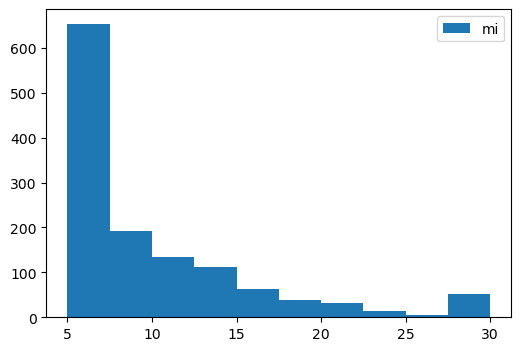

In [10]:
plt.figure(figsize=(6,4))
plt.hist(x_rest_all[4][:,3,:].flatten(), label='mi')
plt.legend()
plt.show()

### condition effect analysis for each parameters across subects in each session 

In [11]:
#to store p-values--(gei, gii, tau_e, tau_i)
### for MI V. Rest--session-4
sess=4
pval_all_reg_top = np.zeros((len(all_regions_idx), 4))
for i in range(len(all_regions_idx)):
    pval_all_reg_top[i,0]=wilcoxon(x_mi_all[sess][all_regions_idx[i],0,:],x_rest_all[sess][all_regions_idx[i],0,:])[1] #gei
    pval_all_reg_top[i,1]=wilcoxon(x_mi_all[sess][all_regions_idx[i],1,:],x_rest_all[sess][all_regions_idx[i],1,:])[1] #gii
    pval_all_reg_top[i,2]=wilcoxon(x_mi_all[sess][all_regions_idx[i],2,:],x_rest_all[sess][all_regions_idx[i],2,:])[1] #tau_e
    pval_all_reg_top[i,3]=wilcoxon(x_mi_all[sess][all_regions_idx[i],3,:],x_rest_all[sess][all_regions_idx[i],3,:])[1] #tau_i

# FDR-corrected p-values 
pfdr=np.zeros((len(all_regions_idx), 4))
for i in range(4):
    pfdr[:,i]=fdrcorrection(pval_all_reg_top[:, i])[1]


significant_gei= np.where(pfdr[:,0]< 0.05)[0]
significant_gii= np.where(pfdr[:,1]< 0.05)[0]
significant_tau_e= np.where(pfdr[:,2]< 0.05)[0]
significant_tau_i= np.where(pfdr[:,3]< 0.05)[0]

print("Significant ROIs for gei (pfdr < 0.05):", [all_regions[i] for i in significant_gei])
print("Significant ROIs for gii (pfdr < 0.05):", [all_regions[i] for i in significant_gii])
print("Significant ROIs for tau_e (pfdr < 0.05):", [all_regions[i] for i in significant_tau_e])
print("Significant ROIs for tau_i (pfdr < 0.05):", [all_regions[i] for i in significant_tau_i])

#FDR-corrected p-values matrix for inspection
# print("FDR Corrected p-values matrix for Top Performers:\n", pfdr)
significant_tau_e_lst=list(significant_tau_e)
significant_gii_lst=list(significant_gii)

Significant ROIs for gei (pfdr < 0.05): []
Significant ROIs for gii (pfdr < 0.05): ['postcentral R', 'transversetemporal L']
Significant ROIs for tau_e (pfdr < 0.05): ['bankssts L', 'cuneus L', 'entorhinal L', 'inferiorparietal L', 'inferiorparietal R', 'isthmuscingulate R', 'paracentral L', 'paracentral R', 'pericalcarine L', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral R', 'precuneus L', 'precuneus R', 'supramarginal L', 'supramarginal R', 'transversetemporal L']
Significant ROIs for tau_i (pfdr < 0.05): []


In [16]:
unique_values = set(significant_gei) | set(significant_gii) | set(significant_tau_e)
print("Total values:", len(unique_values))


Total values: 19


### (MI-Rest)/Rest

In [26]:
##tau_e
sess1_mi_rest_tau_e=[[] for _ in range(68)]
sess2_mi_rest_tau_e=[[] for _ in range(68)]
sess3_mi_rest_tau_e=[[] for _ in range(68)]
sess4_mi_rest_tau_e=[[] for _ in range(68)]

 
for k in range(68):
    for j in range(19):
        mi_rest1_tau_e=((x_mi_all[1][k,2,j])-(x_rest_all[1][k,2,j]))/(x_rest_all[1][k,2,j])
        sess1_mi_rest_tau_e[k].append(mi_rest1_tau_e)
        mi_rest2_tau_e=((x_mi_all[2][k,2,j])-(x_rest_all[2][k,2,j]))/(x_rest_all[2][k,2,j])
        sess2_mi_rest_tau_e[k].append(mi_rest2_tau_e)
        mi_rest3_tau_e=((x_mi_all[3][k,2,j])-(x_rest_all[3][k,2,j]))/(x_rest_all[3][k,2,j])
        sess3_mi_rest_tau_e[k].append(mi_rest3_tau_e)
        mi_rest4_tau_e=((x_mi_all[4][k,2,j])-(x_rest_all[4][k,2,j]))/(x_rest_all[4][k,2,j])
        sess4_mi_rest_tau_e[k].append(mi_rest4_tau_e)

In [27]:
##gii
sess1_mi_rest_gii=[[] for _ in range(68)]
sess2_mi_rest_gii=[[] for _ in range(68)]
sess3_mi_rest_gii=[[] for _ in range(68)]
sess4_mi_rest_gii=[[] for _ in range(68)]

 
for k in range(68):
    for j in range(19):
        mi_rest1_gii=((x_mi_all[1][k,1,j])-(x_rest_all[1][k,1,j]))/(x_rest_all[1][k,1,j])
        sess1_mi_rest_gii[k].append(mi_rest1_gii)
        mi_rest2_gii=((x_mi_all[2][k,1,j])-(x_rest_all[2][k,1,j]))/(x_rest_all[2][k,1,j])
        sess2_mi_rest_gii[k].append(mi_rest2_gii)
        mi_rest3_gii=((x_mi_all[3][k,1,j])-(x_rest_all[3][k,1,j]))/(x_rest_all[3][k,1,j])
        sess3_mi_rest_gii[k].append(mi_rest3_gii)
        mi_rest4_gii=((x_mi_all[4][k,1,j])-(x_rest_all[4][k,1,j]))/(x_rest_all[4][k,1,j])
        sess4_mi_rest_gii[k].append(mi_rest4_gii)

### session by session progress in significant regions, starting from session-4

In [28]:
def find_mean(data):
    return [np.mean(lst) for lst in data]

def plot_violin(data, means, param, region, state):
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=data, density_norm='width', inner=None, palette="muted", orient="v")
    sns.stripplot(data=data, color="black", size=5, jitter=False, orient="v")

    for i, mean in enumerate(means):
        plt.scatter(i, mean, color="red", zorder=3, label="Mean" if i == 0 else "")
    
    plt.plot(range(len(means)), means, color="blue", linestyle="-", zorder=2)
    plt.xlabel("Sessions", fontsize=12)
    plt.ylabel(f"{param}", fontsize=12)
    plt.title(f"MEG-Progress in {state} in {region}", fontsize=14)
    plt.xticks(ticks=range(len(data)), labels=range(1, len(data) + 1), fontsize=10)

    plt.grid(axis='y', linestyle='', alpha=0)  
    plt.yticks(fontsize=10)  
    plt.legend(loc="upper right")
    plt.show()

In [29]:
# ##tau_e
# cnt=0
# for i in significant_tau_e:
#     cnt+=1
#     print(all_regions[i])
# print(cnt)

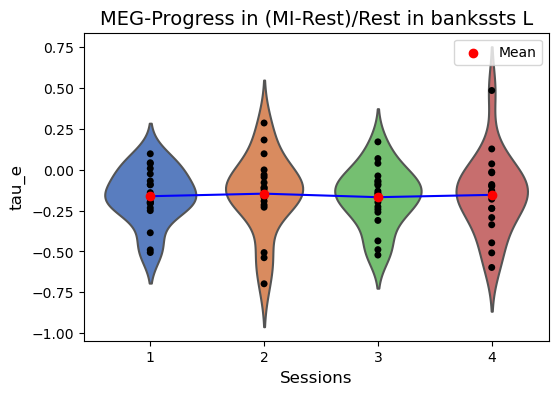

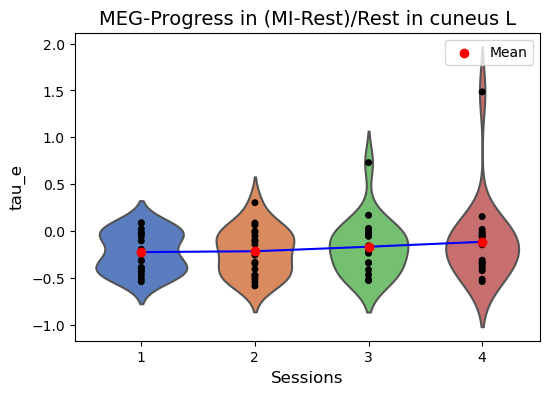

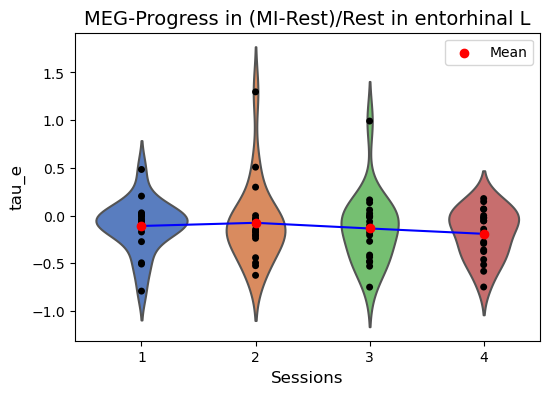

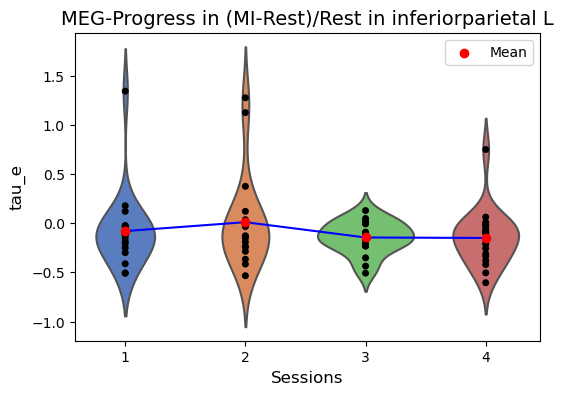

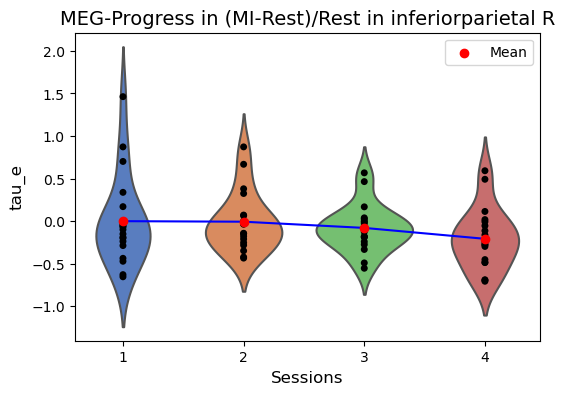

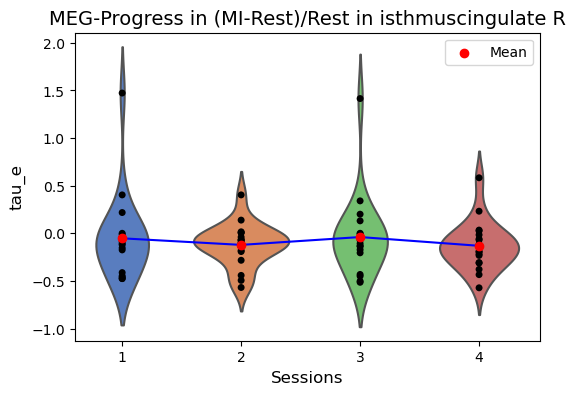

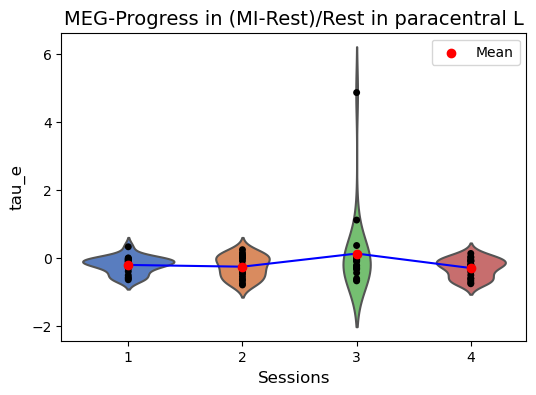

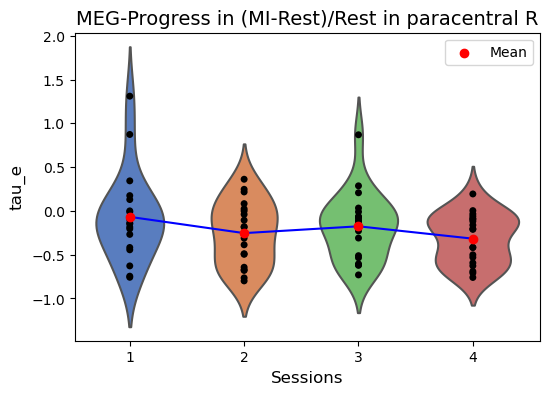

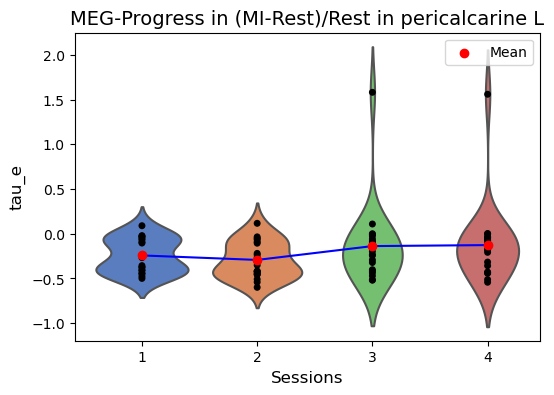

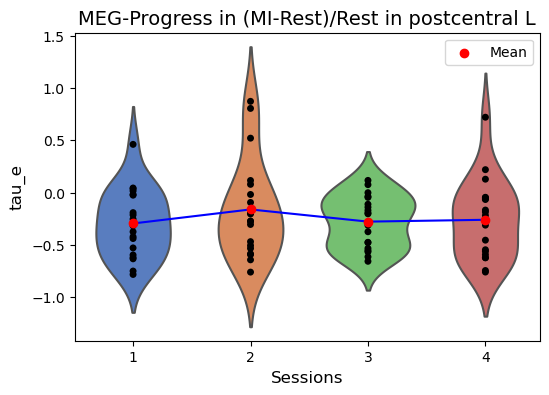

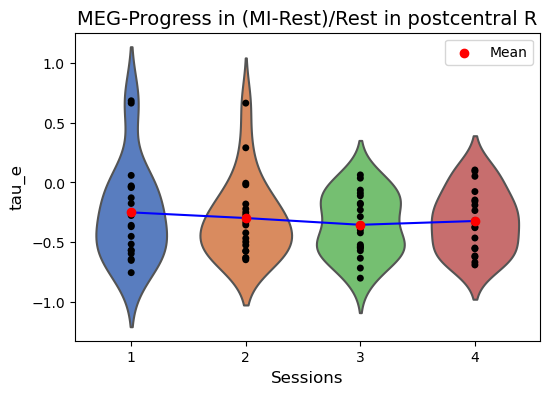

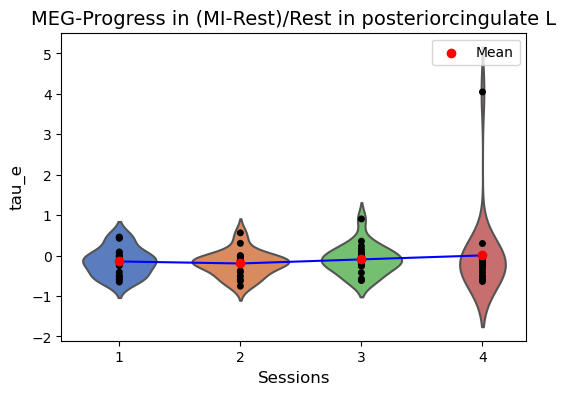

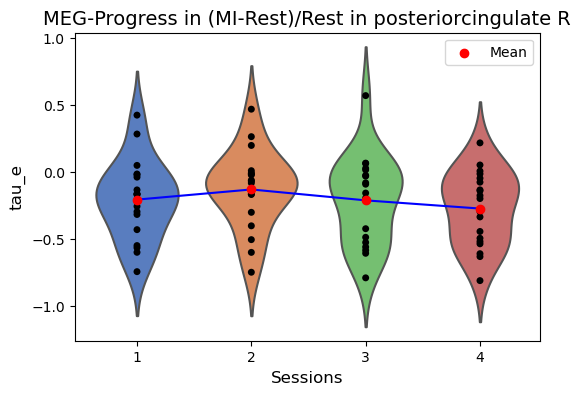

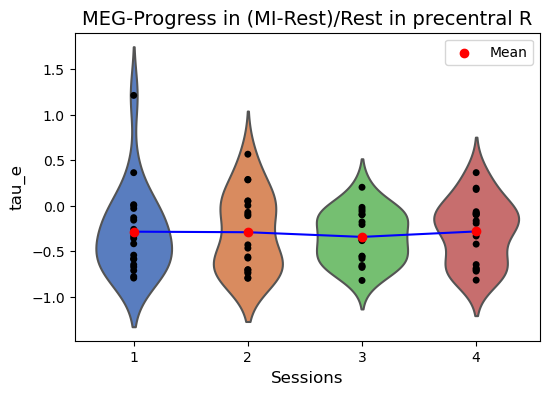

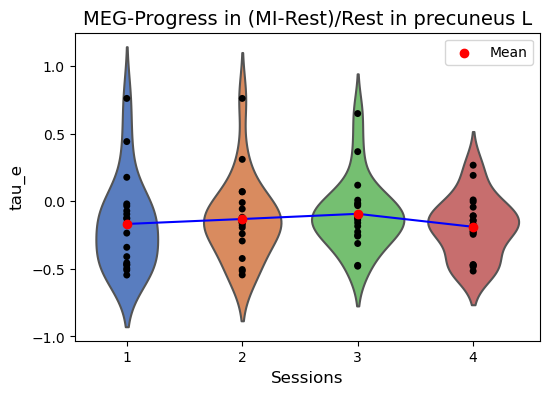

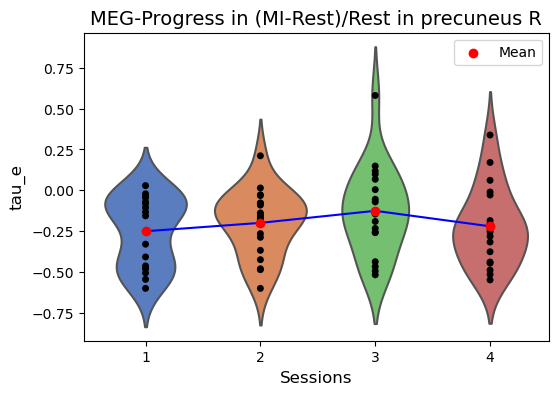

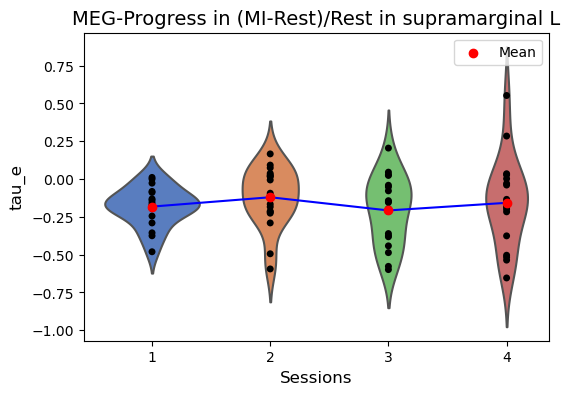

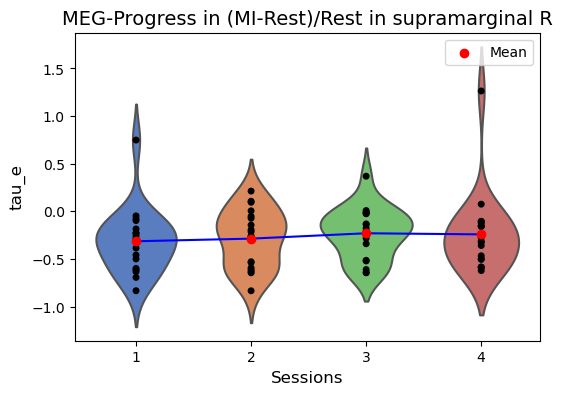

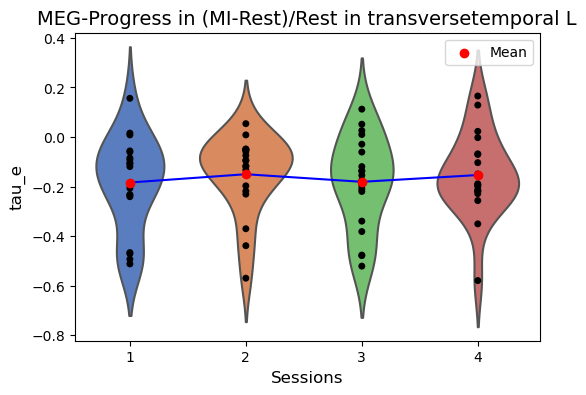

In [33]:

##for tau_e--(MI-Rest)/Rest
def main():
    for i in significant_tau_e:
      data = [sess1_mi_rest_tau_e[i],sess2_mi_rest_tau_e[i],sess3_mi_rest_tau_e[i],sess4_mi_rest_tau_e[i]]
      means = find_mean(data)
      parameter="tau_e"
      state="(MI-Rest)/Rest"
      plot_violin(data, means, parameter, all_regions[i],state)

if __name__ == "__main__":
    main()


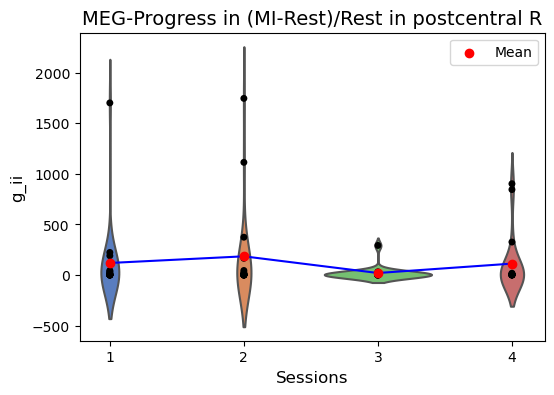

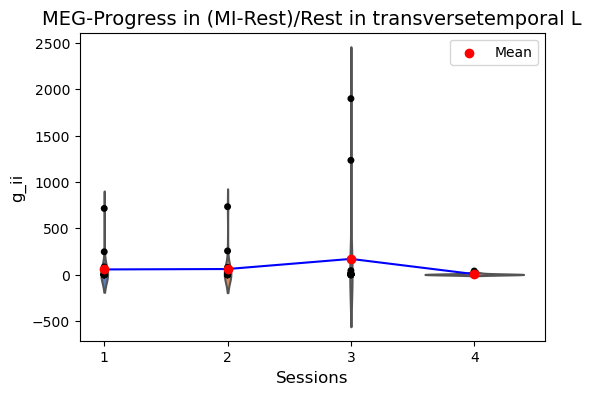

In [32]:

##for gii--(MI-Rest)/Rest
def main():
    for i in significant_gii:
      data = [sess1_mi_rest_gii[i],sess2_mi_rest_gii[i],sess3_mi_rest_gii[i],sess4_mi_rest_gii[i]]
      means = find_mean(data)
      parameter="g_ii"
      state="(MI-Rest)/Rest"
      plot_violin(data, means, parameter, all_regions[i],state)

if __name__ == "__main__":
    main()


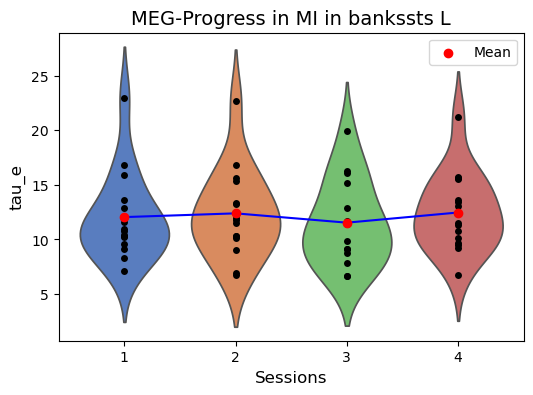

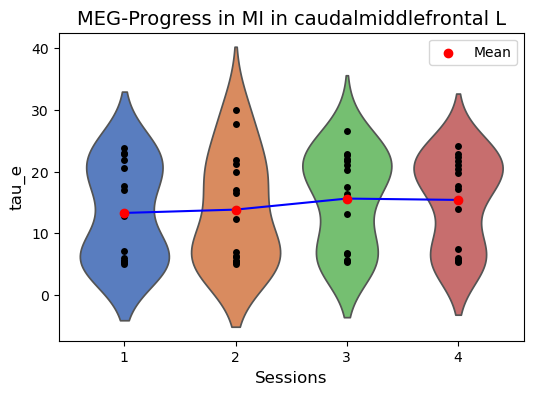

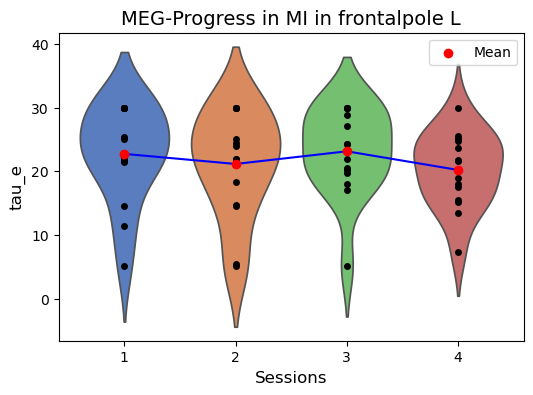

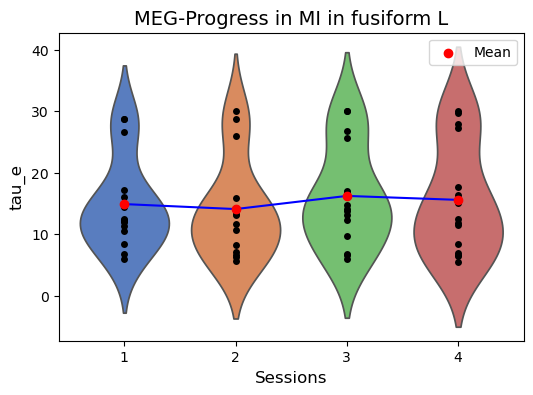

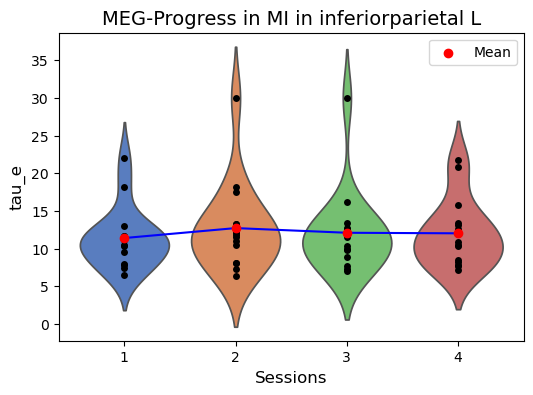

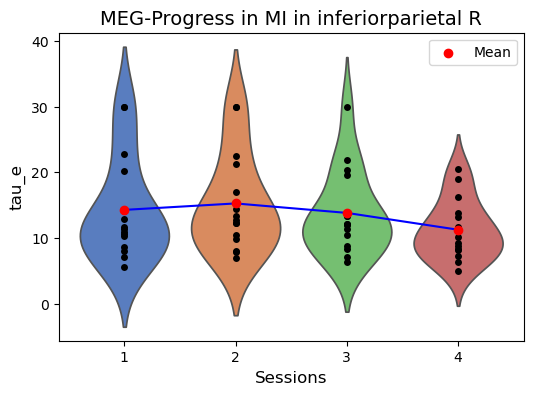

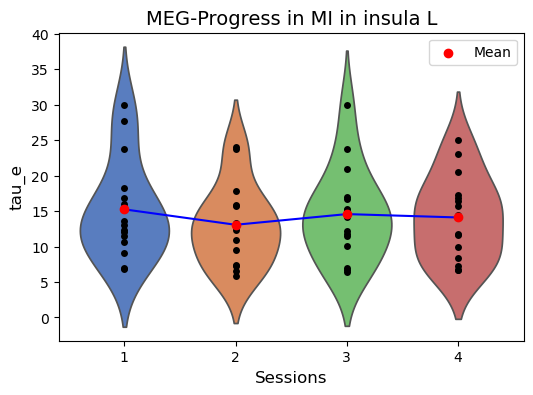

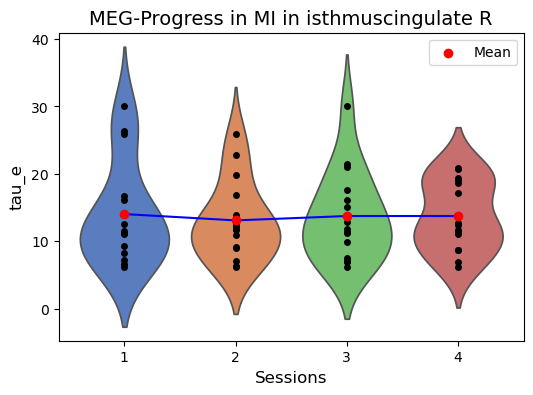

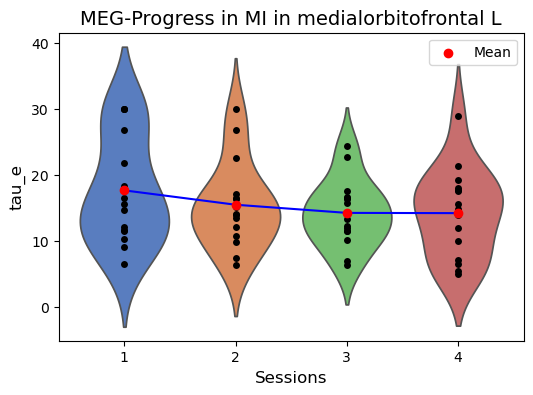

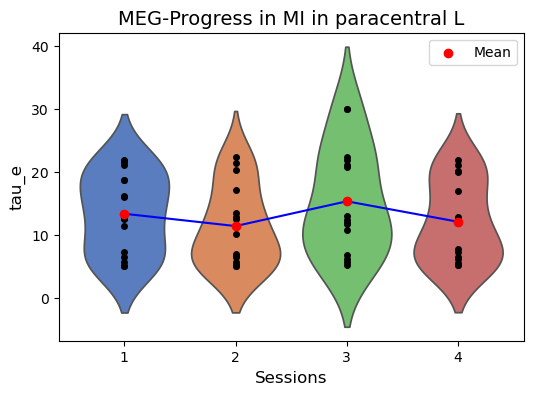

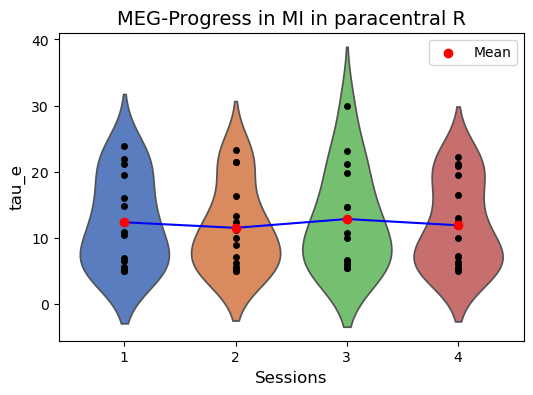

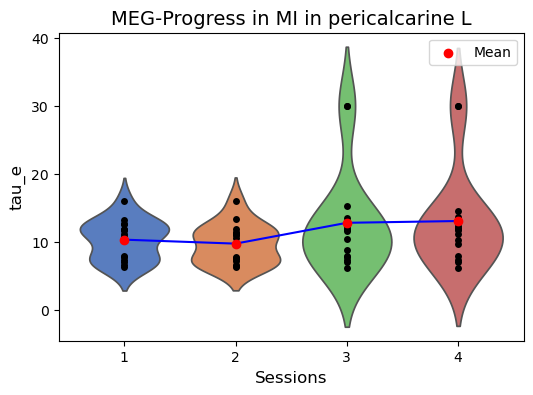

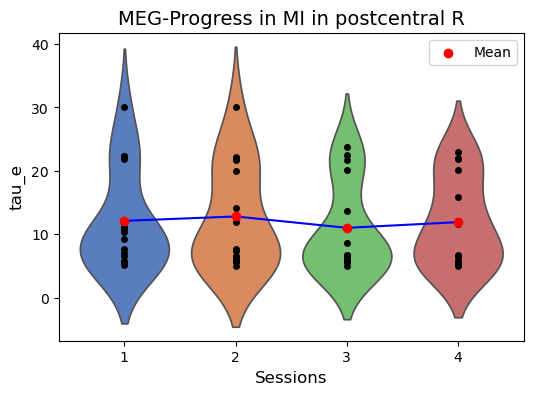

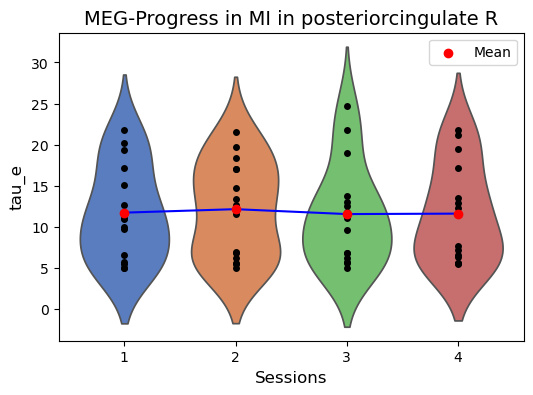

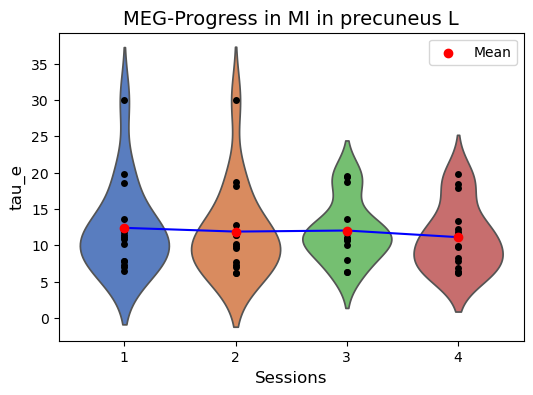

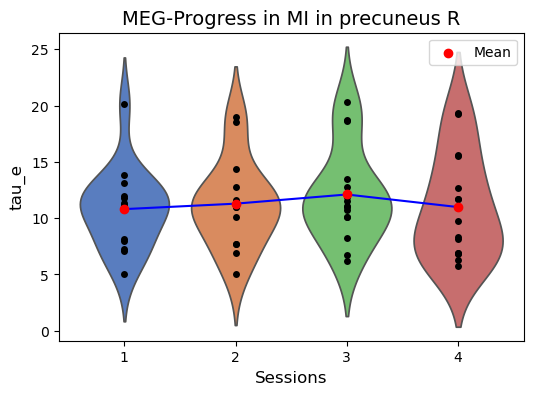

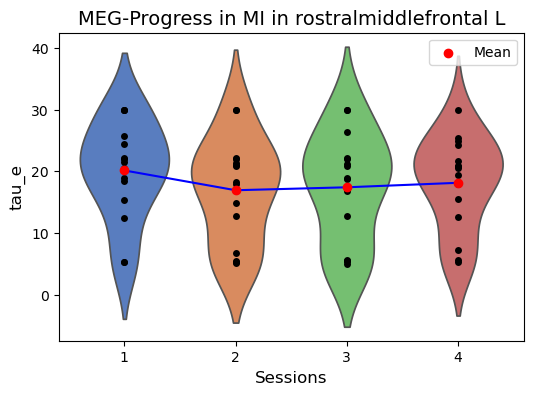

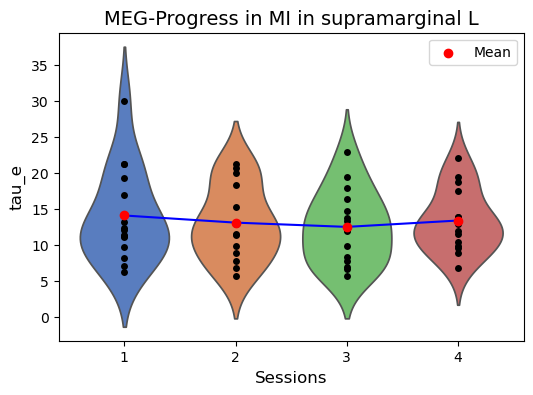

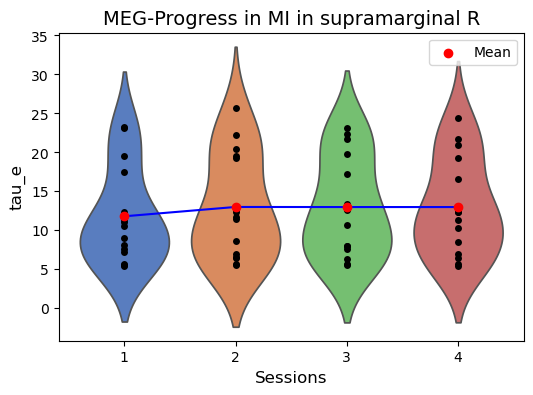

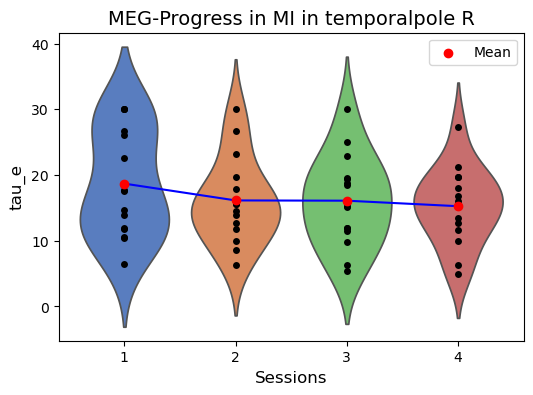

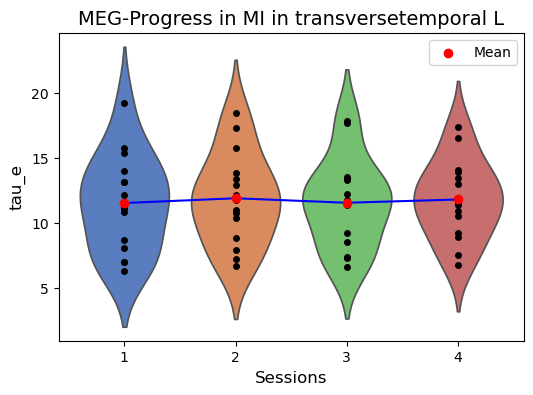

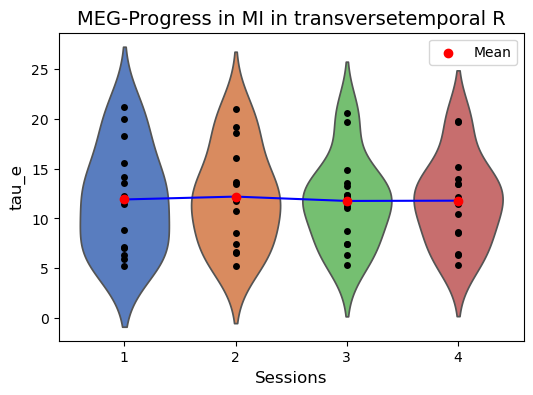

In [62]:
##for tau_e
def main():
    for i in significant_tau_e:
      data = [x_mi_all[1][i,2,top_performers], x_mi_all[2][i,2,top_performers], x_mi_all[3][i,2,top_performers], x_mi_all[4][i,2,top_performers]]
      means = find_mean(data)
      parameter="tau_e"
      state="MI"
      plot_violin(data, means, parameter, all_regions[i], state)

if __name__ == "__main__":
    main()


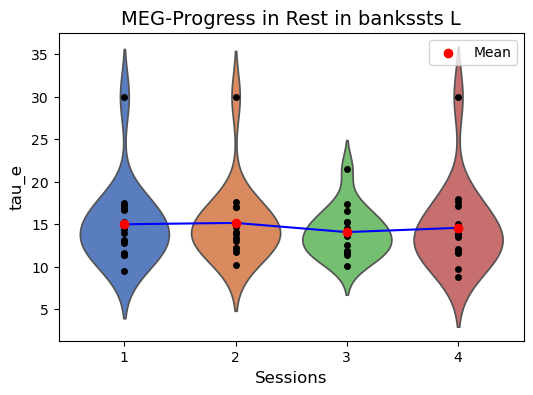

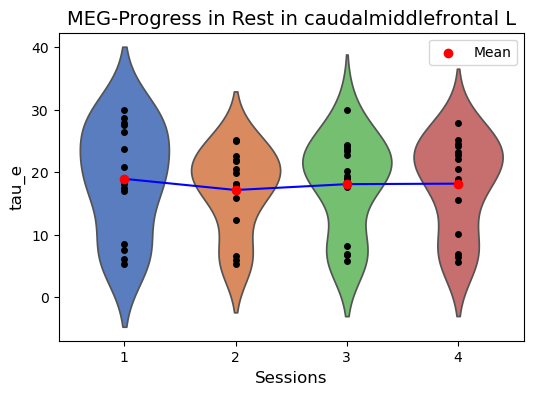

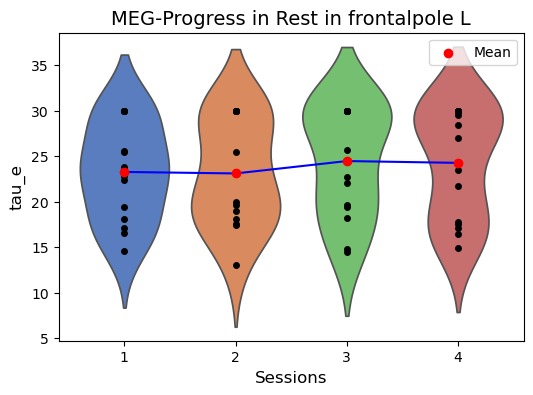

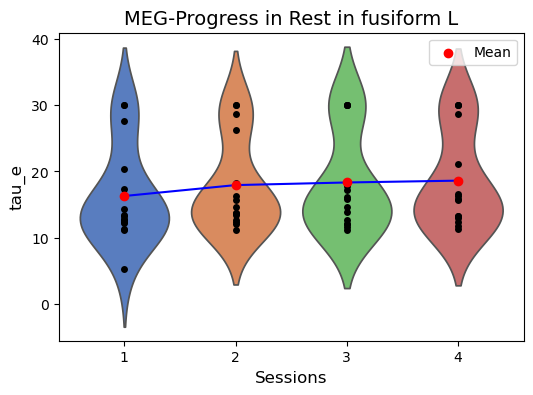

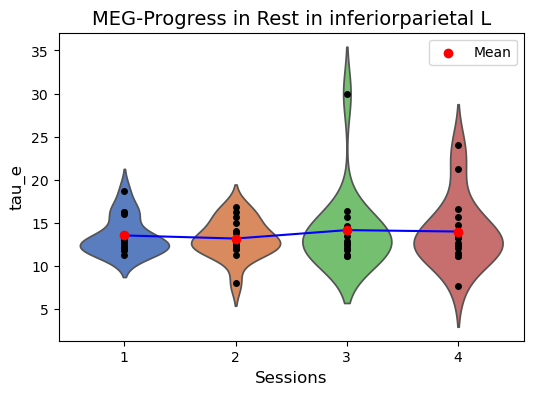

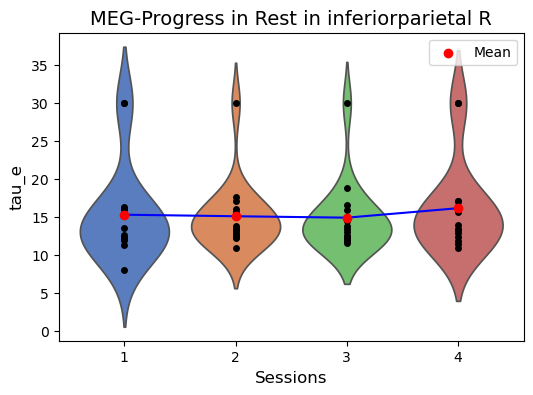

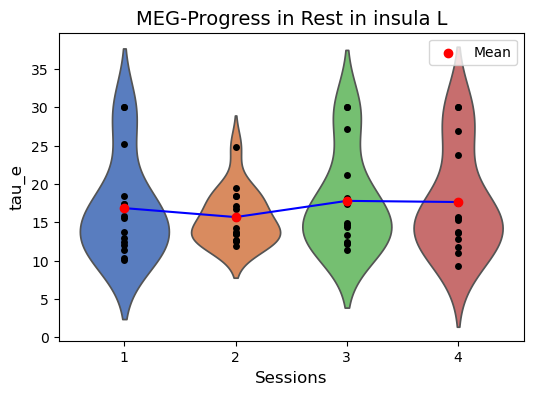

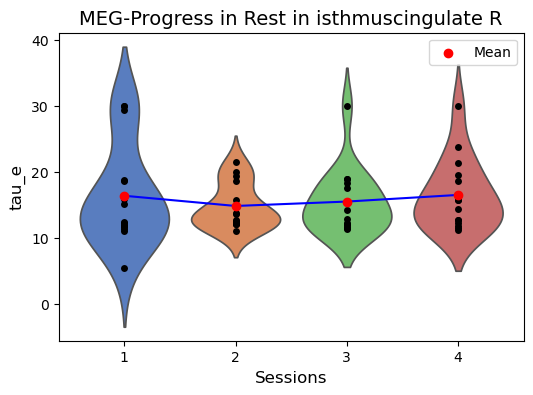

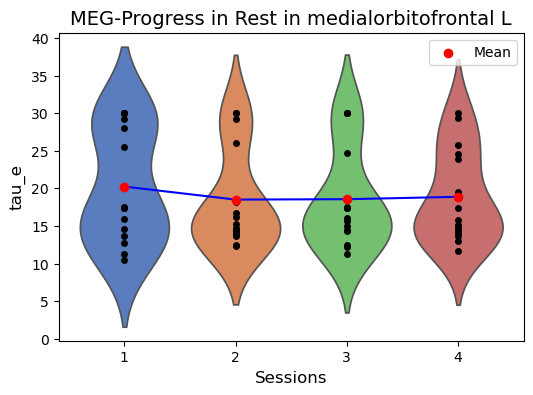

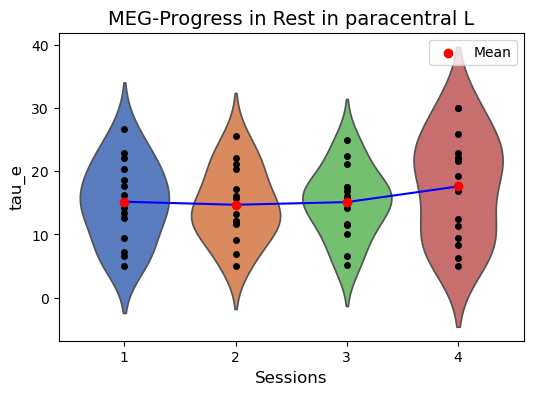

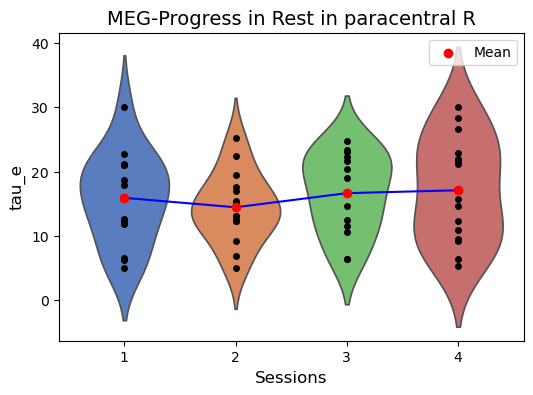

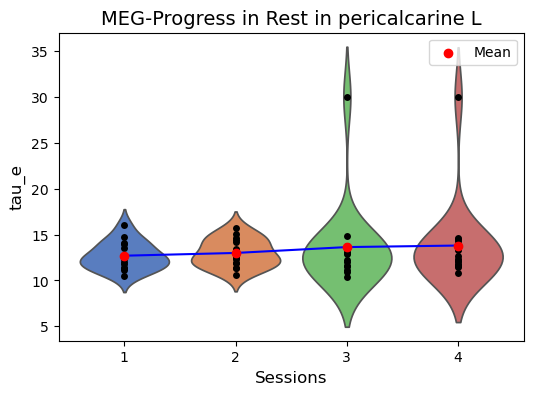

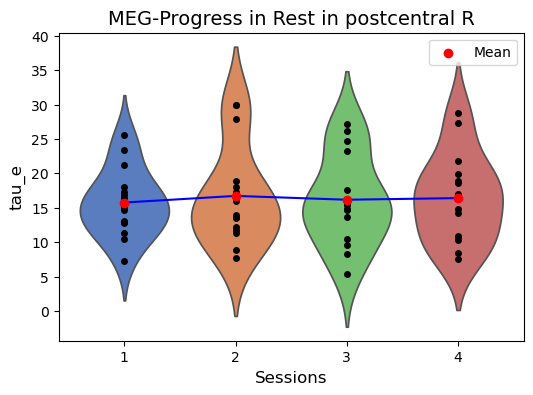

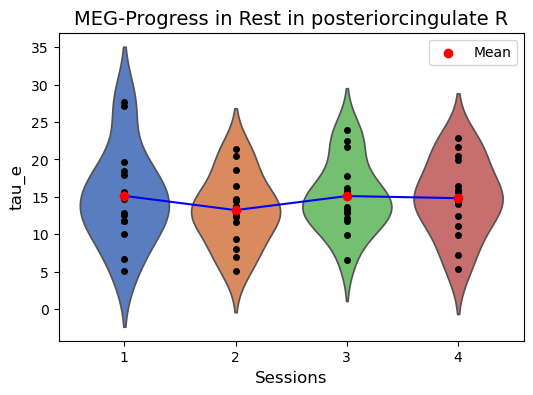

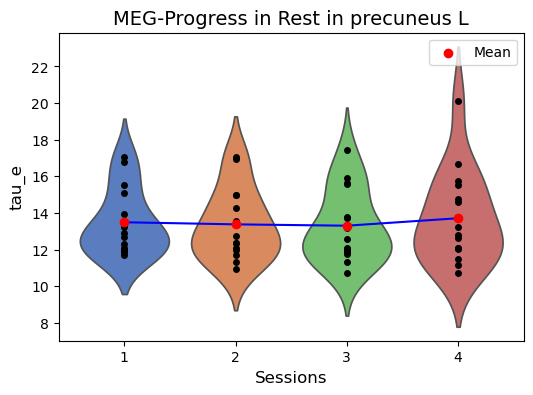

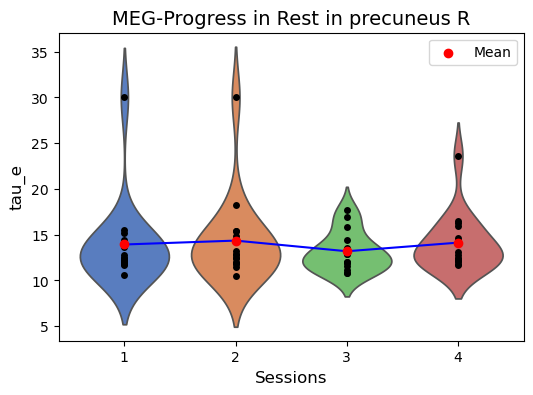

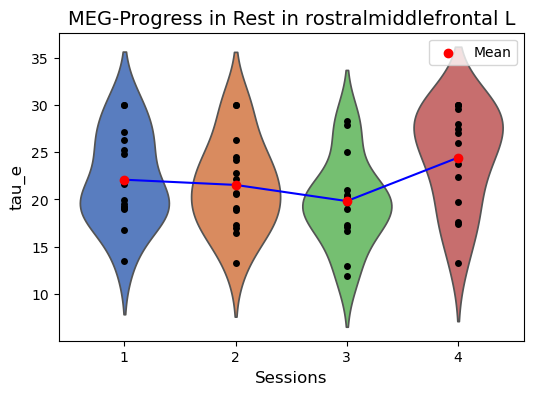

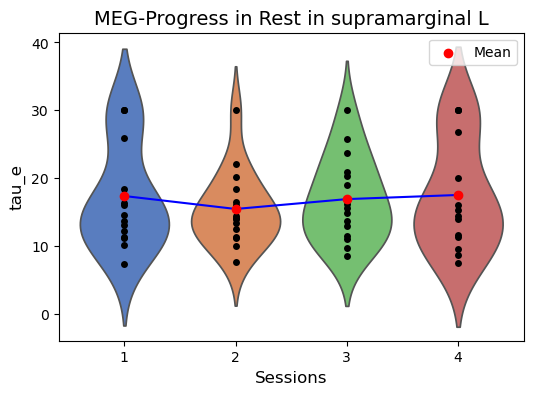

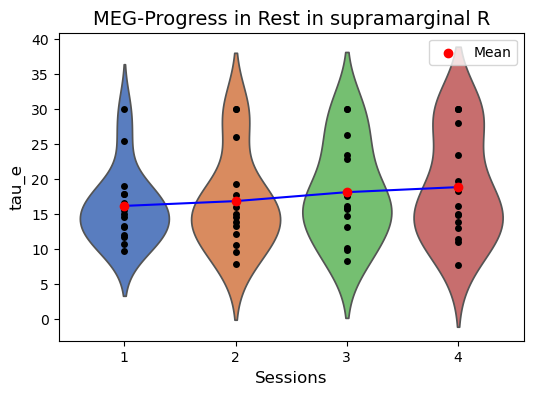

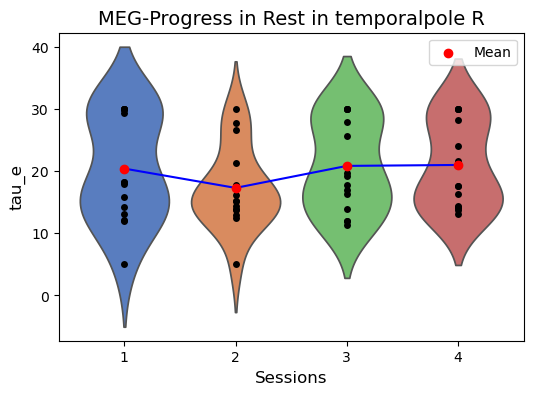

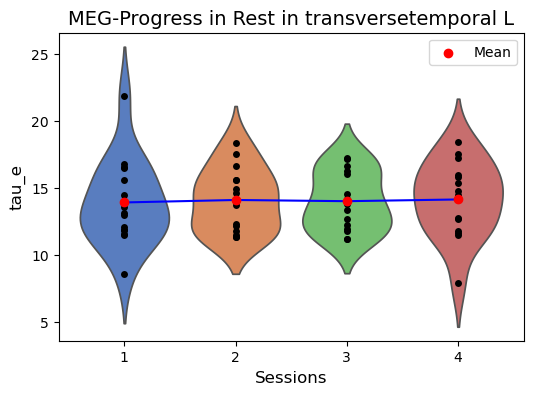

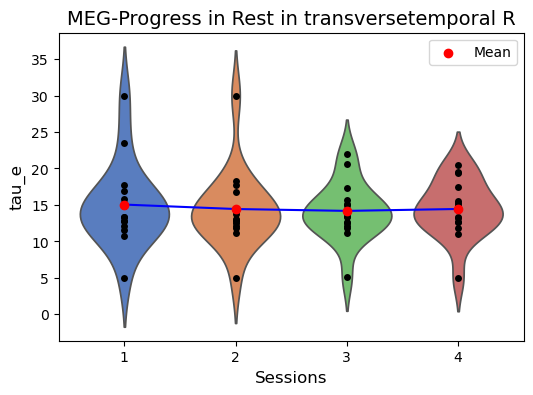

In [63]:
##for tau_e
def main():
    for i in significant_tau_e:
      data = [x_rest_all[1][i,2,top_performers], x_rest_all[2][i,2,top_performers], x_rest_all[3][i,2,top_performers], x_rest_all[4][i,2,top_performers]]
      means = find_mean(data)
      parameter="tau_e"
      state="Rest"
      plot_violin(data, means, parameter, all_regions[i], state)

if __name__ == "__main__":
    main()


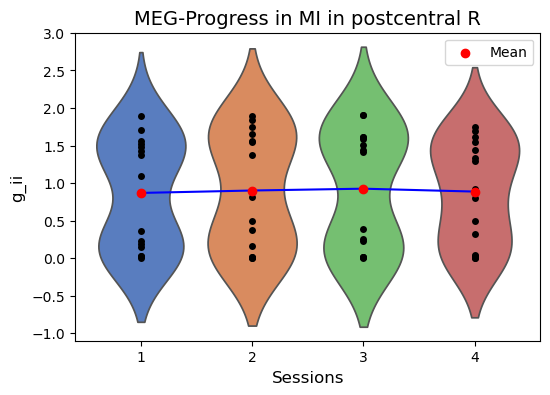

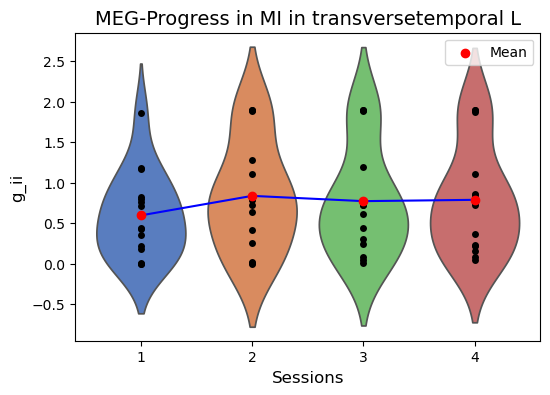

In [64]:
##for g_ii
def main():
    for i in significant_gii:
      data = [x_mi_all[1][i,1,top_performers], x_mi_all[2][i,1,top_performers], x_mi_all[3][i,1,top_performers], x_mi_all[4][i,1,top_performers]]
      means = find_mean(data)
      parameter="g_ii"
      state="MI"
      plot_violin(data, means, parameter, all_regions[i], state)

if __name__ == "__main__":
    main()

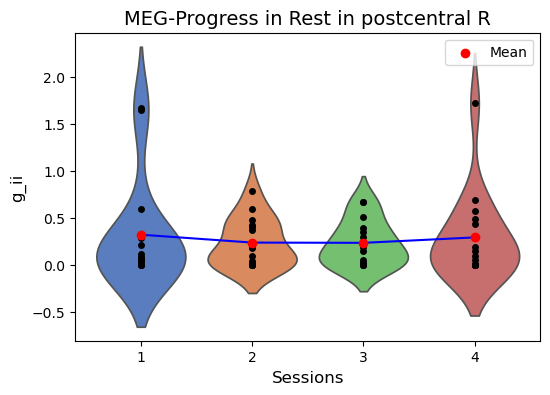

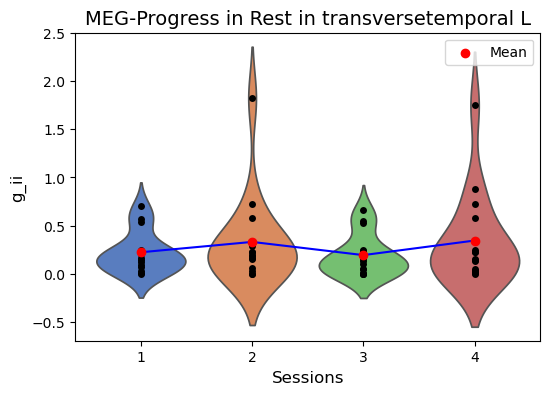

In [65]:
##for g_ii
def main():
    for i in significant_gii:
      data = [x_rest_all[1][i,1,top_performers], x_rest_all[2][i,1,top_performers], x_rest_all[3][i,1,top_performers], x_rest_all[4][i,1,top_performers]]
      means = find_mean(data)
      parameter="g_ii"
      state="Rest"
      plot_violin(data, means, parameter, all_regions[i], state)

if __name__ == "__main__":
    main()

In [12]:
##ALL sessions-- all regions across all-performers
compare=["MI vs Rest", "MI vs Base", "Base vs Rest"]
num_compare=len(compare)
num_sess=4 
#3-comparison x 4-sessions x regions x 4-params
pval_all_compare=np.zeros((num_compare, num_sess, len(all_regions_idx), 4))
pfdr_all_compare=np.zeros((num_compare, num_sess, len(all_regions_idx), 4))


for idx,comp in enumerate(compare):
    for sess in range(1, num_sess+1): 
        for i in range(len(all_regions_idx)):
            if comp=="MI vs Rest":
                x1, x2 = x_mi_all[sess], x_rest_all[sess]
            elif comp=="MI vs Base":
                x1, x2 = x_mi_all[sess], x_base_all[sess]
            elif comp=="Base vs Rest":
                x1, x2 = x_base_all[sess], x_rest_all[sess]
            
            pval_all_compare[idx,sess-1, i, 0] = wilcoxon(x1[all_regions_idx[i],0,:], x2[all_regions_idx[i],0,:])[1]  # gei
            pval_all_compare[idx,sess-1, i, 1] = wilcoxon(x1[all_regions_idx[i],1,:], x2[all_regions_idx[i],1,:])[1]  # gii
            pval_all_compare[idx,sess-1, i, 2] = wilcoxon(x1[all_regions_idx[i],2,:], x2[all_regions_idx[i],2,:])[1]  # tau_e
            pval_all_compare[idx,sess-1, i, 3] = wilcoxon(x1[all_regions_idx[i],3,:], x2[all_regions_idx[i],3,:])[1]  # tau_i

        for feature in range(4):
            pfdr_all_compare[idx,sess-1,:, feature] = fdrcorrection(pval_all_compare[idx, sess-1, :, feature])[1]


sig_reg_sess={f"sess{sess}": {comp: {feat: [] for feat in ["gei", "gii", "tau_e", "tau_i"]} for comp in compare} for sess in range(1, num_sess+1)}

for idx,comp in enumerate(compare):
    for sess in range(1, num_sess+1):  
        for feature_idx, feature_name in enumerate(["gei", "gii", "tau_e", "tau_i"]):
            sig_indices = np.where(pfdr_all_compare[idx, sess-1, :, feature_idx]<=0.05)[0]
            sig_regions = [all_regions[i] for i in sig_indices]
            sig_reg_sess[f"sess{sess}"][comp][feature_name] = sig_regions


for sess in range(1, num_sess + 1):
    print(f"\nSR FOR SESSION-{sess}:")
    for comp in compare:
        print(f"  Comparison:{comp}")
        for feature in ["gei", "gii", "tau_e", "tau_i"]:
            print(f" SR for {feature}: {sig_reg_sess[f'sess{sess}'][comp][feature]}")



SR FOR SESSION-1:
  Comparison:MI vs Rest
 SR for gei: ['inferiorparietal R', 'lateraloccipital L', 'parsopercularis L', 'superiorparietal R']
 SR for gii: ['transversetemporal L']
 SR for tau_e: ['bankssts L', 'caudalanteriorcingulate R', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'cuneus L', 'cuneus R', 'entorhinal R', 'fusiform L', 'inferiortemporal L', 'middletemporal L', 'paracentral L', 'parsopercularis L', 'pericalcarine L', 'pericalcarine R', 'postcentral L', 'postcentral R', 'posteriorcingulate R', 'precentral L', 'precentral R', 'precuneus R', 'superiorfrontal R', 'superiortemporal L', 'supramarginal L', 'supramarginal R', 'transversetemporal L', 'transversetemporal R']
 SR for tau_i: []
  Comparison:MI vs Base
 SR for gei: []
 SR for gii: []
 SR for tau_e: []
 SR for tau_i: []
  Comparison:Base vs Rest
 SR for gei: []
 SR for gii: ['transversetemporal L']
 SR for tau_e: ['bankssts L', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'cuneus L', 'cuneus R', 'entorhin